In [1]:
import dask.dataframe as dd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# Function to add edges to the graph incrementally
def add_edges_to_graph(df_chunk, graph):
    for _, row in df_chunk.iterrows():
        graph.add_edge(row['read1'], row['read2'], weight=row['distance'])
    return graph

# Load the data using Dask
df = dd.read_csv('E:/bams/extended/closest_knn.txt', delim_whitespace=True, header=None, names=['read1', 'read2', 'distance'])

# Randomly sample 1/4 of the rows
sampled_df = df.sample(frac=0.25, random_state=42)

In [ ]:
import pickle

# Initialize an empty graph
G = nx.Graph()

# Process data in chunks to build the graph incrementally
td = sampled_df.to_delayed()[:250]
num_chunks = len(td)
for idx, chunk in enumerate(td):
    if (idx % 10) == 0:
        print("Adding chunk {0} of {1}...".format(idx, num_chunks))
    chunk = chunk.compute()
    G = add_edges_to_graph(chunk, G)

graph_output_path = 'E:/bams/extended/G.pkl'
with open(graph_output_path, 'wb') as f:
    pickle.dump(G, f)

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G, weight='distance')

partition_output_path = 'E:/bams/extended/partition.pkl'
with open(partition_output_path, 'wb') as f:
    pickle.dump(partition, f)

# Save clusters to a file
with open('E:/bams/extended/clusters.txt', 'w') as f:
    for node, cluster in partition.items():
        f.write(f"{node}\t{cluster}\n")

In [12]:
from collections import Counter

cluster_counts = Counter(partition.values())
num_clusters = len(cluster_counts)

Cluster histogram saved successfully.


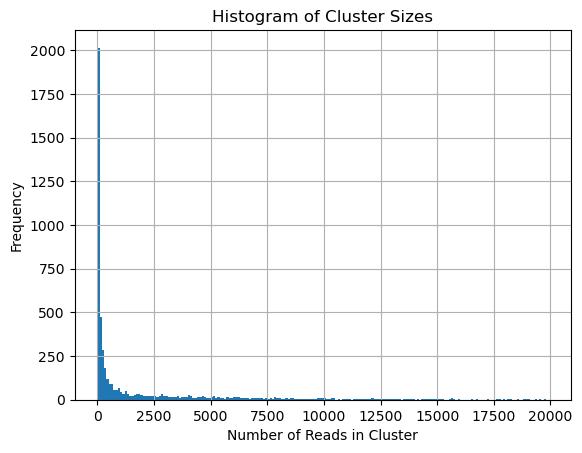

In [22]:
import matplotlib.pyplot as plt

# Plot a histogram of the cluster counts
plt.figure()
plt.hist(cluster_counts.values(), bins=np.arange(1, 20000, 100))
plt.xlabel('Number of Reads in Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Sizes')
plt.grid(True)
plt.savefig('E:/bams/extended/cluster_histogram.png')
print("Cluster histogram saved successfully.")

In [37]:
import pandas as pd

bed_file = 'E:/bams/extended/extended_intergenic_reads_filt.bed'  # Replace with your BED file path
bed_df = pd.read_csv(bed_file, sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])

C:\Users\TLab\AppData\Local\Temp\ipykernel_20076\3330564701.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bed_df = pd.read_csv(bed_file, sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter clusters with more than 10,000 reads
large_clusters = {cluster_id: count for cluster_id, count in cluster_counts.items() if count > 10000}

# Calculate the genomic range for each large cluster
loci_ranges = {}
for cluster_id in large_clusters:
    print("Cluster ID#{0}".format(cluster_id))
    reads_in_cluster = [node for node, cluster in partition.items() if cluster == cluster_id]
    cluster_bed_df = bed_df[bed_df['name'].isin(reads_in_cluster)]
    if not cluster_bed_df.empty:
        min_start = np.round(np.percentile(cluster_bed_df['start'], 5)).astype(int)
        max_end = np.round(np.percentile(cluster_bed_df['end'], 95)).astype(int)
        mean_start = np.round(cluster_bed_df['start'].mean()).astype(int)
        mean_end = np.round(cluster_bed_df['end'].mean()).astype(int)
        chrom = cluster_bed_df['chrom'].mode()[0]
        loci_ranges[cluster_id] = (chrom, min_start, max_end, mean_start, mean_end)
        
        # # Plot the distribution of read alignments for the current cluster
        # plt.figure()
        # plt.hist(cluster_bed_df['start'], bins=50, alpha=0.5, label='Start Positions')
        # plt.hist(cluster_bed_df['end'], bins=50, alpha=0.5, label='End Positions')
        
        # # Add vertical lines for 5th percentile, 95th percentile, and mean positions
        # plt.axvline(min_start, color='blue', linestyle='dashed', linewidth=1, label='5th Percentile Start')
        # plt.axvline(max_end, color='red', linestyle='dashed', linewidth=1, label='95th Percentile End')
        # plt.axvline(mean_start, color='green', linestyle='dashed', linewidth=1, label='Mean Start')
        # plt.axvline(mean_end, color='orange', linestyle='dashed', linewidth=1, label='Mean End')
        
        # plt.xlabel('Genomic Position')
        # plt.ylabel('Frequency')
        # plt.title(f'Cluster {cluster_id} Read Alignments')
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(f'E:/bams/extended/clusters/cluster_{cluster_id}_read_distribution.png')
        # plt.close()

In [1]:
# Sort the loci by length, from smallest to largest
sorted_loci_ranges = sorted(loci_ranges.items(), key=lambda x: x[1][2] - x[1][1])

# Print the sorted loci ranges
print("Sorted loci ranges for clusters with more than 10,000 reads (by length):")
for cluster_id, (chrom, min_start, max_end, mean_start, mean_end) in sorted_loci_ranges:
    print(f"Cluster {cluster_id}: {chrom}:{min_start}-{max_end} (Length: {max_end - min_start})")

NameError: name 'loci_ranges' is not defined